In [ ]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords


In [ ]:
#Load and explore all four CSVs
# Define dataset paths
data_path = os.path.join(path, "dataset")

# Load all CSVs
gossipcop_fake = pd.read_csv(os.path.join(data_path, "gossipcop_fake.csv"))
gossipcop_real = pd.read_csv(os.path.join(data_path, "gossipcop_real.csv"))
politifact_fake = pd.read_csv(os.path.join(data_path, "politifact_fake.csv"))
politifact_real = pd.read_csv(os.path.join(data_path, "politifact_real.csv"))

# Display their shapes
print("Gossipcop Fake:", gossipcop_fake.shape)
print("Gossipcop Real:", gossipcop_real.shape)
print("Politifact Fake:", politifact_fake.shape)
print("Politifact Real:", politifact_real.shape)

# See a sample
print("\nSample columns in gossipcop_fake:")
print(gossipcop_fake.head(2))


Gossipcop Fake: (5323, 4)
Gossipcop Real: (16817, 4)
Politifact Fake: (432, 4)
Politifact Real: (624, 4)

Sample columns in gossipcop_fake:
                     id                                           news_url  \
0  gossipcop-2493749932  www.dailymail.co.uk/tvshowbiz/article-5874213/...   
1  gossipcop-4580247171  hollywoodlife.com/2018/05/05/paris-jackson-car...   

                                               title  \
0  Did Miley Cyrus and Liam Hemsworth secretly ge...   
1  Paris Jackson & Cara Delevingne Enjoy Night Ou...   

                                           tweet_ids  
0  284329075902926848\t284332744559968256\t284335...  
1  992895508267130880\t992897935418503169\t992899...  


In [7]:
#combine a nd label the data
# Add labels
gossipcop_fake["label"] = 0
gossipcop_real["label"] = 1
politifact_fake["label"] = 0
politifact_real["label"] = 1

# Combine all into one dataset
data = pd.concat([gossipcop_fake, gossipcop_real, politifact_fake, politifact_real], ignore_index=True)

# Shuffle the data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print("Combined dataset shape:", data.shape)
print("Columns:", data.columns.tolist())
print("\nLabel distribution:")
print(data["label"].value_counts())


Combined dataset shape: (23196, 5)
Columns: ['id', 'news_url', 'title', 'tweet_ids', 'label']

Label distribution:
label
1    17441
0     5755
Name: count, dtype: int64


In [ ]:
#clean and prepare the text 
nltk.download('stopwords')

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)          # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text)         # Remove special chars/numbers
    text = " ".join(word for word in text.split() if word not in stopwords.words("english"))
    return text

data["clean_title"] = data["title"].apply(clean_text)

print("Cleaned sample:")
print(data[["title", "clean_title"]].head(3))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaned sample:
                                               title  \
0  Will Bindi Irwin Get Married to Boyfriend Chan...   
1  Bob Harper: Howard Stern Reached Out to Me Aft...   
2  'Guardians of the Galaxy Vol. 2' cast play Gue...   

                                         clean_title  
0  bindi irwin get married boyfriend chandler powell  
1       bob harper howard stern reached heart attack  
2  guardians galaxy vol cast play guess guardian ...  


In [9]:
#Split and Train a Model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,roc_curve, auc,confusion_matrix

X = data["clean_title"]
y = data["label"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Model
model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred) * 100)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 83.83620689655173

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.47      0.59      1162
           1       0.84      0.96      0.90      3478

    accuracy                           0.84      4640
   macro avg       0.83      0.71      0.75      4640
weighted avg       0.83      0.84      0.82      4640



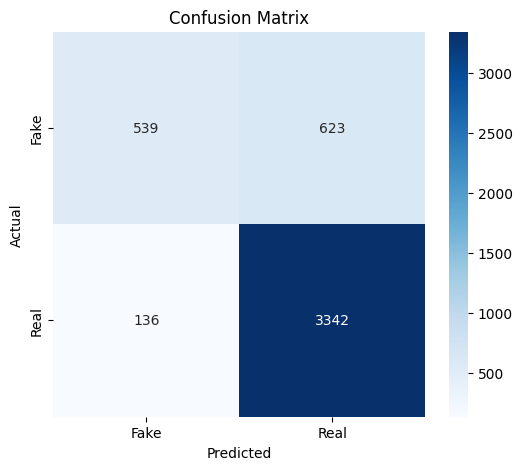

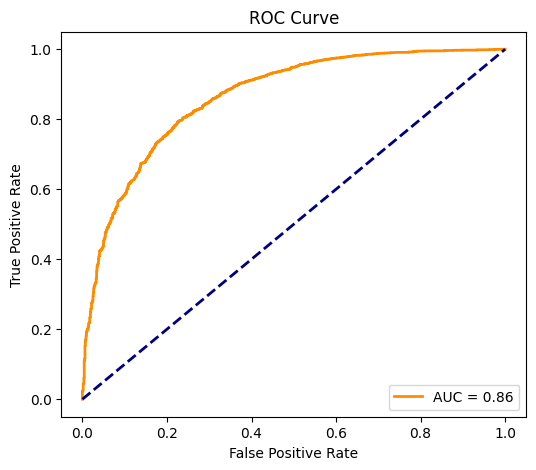

In [20]:
#⃣Confusion Matrix Visualization
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# -----------------------------
# ROC Curve
# -----------------------------
y_pred_prob = model.predict_proba(X_test_tfidf)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [13]:
import joblib
import os

# Create models folder
os.makedirs('models', exist_ok=True)

joblib.dump(model, 'models/fakenewsnet_model.pkl')
joblib.dump(vectorizer, 'models/fakenewsnet_vectorizer.pkl')

print("FAKENEWSNET MODEL & VECTORIZER SAVED!")
print("Files: fakenewsnet_model.pkl, fakenewsnet_vectorizer.pkl")



FAKENEWSNET MODEL & VECTORIZER SAVED!
Files: fakenewsnet_model.pkl, fakenewsnet_vectorizer.pkl


In [14]:
test_model = joblib.load('models/fakenewsnet_model.pkl')
test_vec = joblib.load('models/fakenewsnet_vectorizer.pkl')
print("Model:", type(test_model))
print("Vectorizer:", type(test_vec))


Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Vectorizer: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
